# 2015 Flight Delays
#### Pre-Introduction Begining with importing libraries and Files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import seaborn as sns

Using pandas to import our three `.csv` files, flights, aiports, and airlines. Flights uses a dictionary to coerce airport IATA codes to strings as some are mismatched.

In [2]:
flights_df = pd.read_csv('flights.csv', dtype = {'ORIGIN_AIRPORT': str, 'DESTINATION_AIRPORT': str})
airports_df = pd.read_csv('airports.csv')
airlines_df = pd.read_csv('airlines.csv')

This will lay out some ground work for loading shapefiles for later mapping.

In [3]:
url_state = 'https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip'

state_gdf = gpd.read_file(url_state)

## Introduction

#### The Problem
We all travel, many of us use airports often, and experience delays. Delays seem to be more common these days, and we even expect and plan for them in our travels. Wether it be waiting on the plane to arrive or a storm, these delays can manifest at single choke points and effect the whole system, often as a domino effect. As an aviation enthusiest I found this topic interesting and wanted to explore some data that airlines and government have collected to gain insight on our airport systems. In this exploration I will dive into some flights, and our main choke points in our country for commercial air travel. Some quesions I am looking into are:
- What are all the airports in this set?
- What carrier has the worst delays?
- What airports have the worst delays?
- What are the busiest airports, how do they fit into delay stats?
- Is Hub and Spoke model a major cause?

Many of these topics have been looked into by the Department of Transportation, Federal Aviation Administration, and many other agencies as congestion has grown and many airports approaching maximum capacity.

#### The Data
The data being used in this exploration is sourced from  [Kaggle](https://www.kaggle.com/usdot/flight-delays?). The set itself is posted by the U.S Department of Transportation (DOT). Direct access to this data has been difficult to find, so I have decided to stick with this dataset for now, though it does closely resemble their aggregations. [DOT Stats](https://www.transtats.bts.gov/HomeDrillChart.asp). The data includes three tables *flights, airports, and airlines* with flights being the meat, airports containing location information, and airlines containing abbrivaiations. To begin we are going to clean our data to make it easy to read and use.

## Cleaning

#### Flights Data
Flights data is the biggest, containing 5.8 million entries. The delay reasons have over 4 million NA values, as the entries do not include delay reason times if there is no delay. to begin I fill those with a more usable value *0*.

In [4]:
flights_df['AIR_SYSTEM_DELAY'] = flights_df['AIR_SYSTEM_DELAY'].fillna(0)
flights_df['SECURITY_DELAY'] = flights_df['SECURITY_DELAY'].fillna(0)
flights_df['AIRLINE_DELAY'] = flights_df['AIRLINE_DELAY'].fillna(0)
flights_df['LATE_AIRCRAFT_DELAY'] = flights_df['LATE_AIRCRAFT_DELAY'].fillna(0)
flights_df['WEATHER_DELAY'] = flights_df['WEATHER_DELAY'].fillna(0)

flights_df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,0.0,0.0,0.0,0.0,0.0
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,0.0,0.0,0.0,0.0,0.0
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,0.0,0.0,0.0,0.0,0.0
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,0.0,0.0,0.0,0.0,0.0
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,0.0,0.0,0.0,0.0,0.0


In [5]:
# the amount of entries
len(flights_df)

5819079

#### Airport Data
The airports dataset is much smaller, and only causes issue with NA values. For this I will drop any NA latitude or longitude values, so we can set up a geometry in a geoDataFrame.

In [6]:
airports_df = airports_df.dropna(subset=['LATITUDE','LONGITUDE'], how='all')
airports_df.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


Setting up the geoDataFrame I use `points_from_xy` to set up the latitude, and longitude as geometry points for future mapping.

In [7]:
airports_df = gpd.GeoDataFrame(airports_df, geometry=gpd.points_from_xy(airports_df.LONGITUDE, airports_df.LATITUDE, crs=4269))

#### Airline Data
The airline dataset is much smaller and I visually checked it, as it acts as a key for airline names.

In [8]:
airlines_df.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


#### The October Problem
Going back to the flights tab, I excluded October data entirely from the table. In the table aiports during this month are referenced using a DOT permanent code which is a 5 digit integer. The rest of the dataset, and in all domestic aviation four character International Air Transportation Association (IATA) codes are used. These you see everywhere PHX for Phoenix, LAX Los Angeles, etc. I still have not been able to create a definative fix, as datasets that can be merged or transcribe these codes have some variation where in code or name where, I can trust to do it automated. Many people have found work arounds on the Kaggle page, but all their data used does not exist, or I ave not been able to find in a similar fasion. This fix would take signifigant time, so cutting October was a simple way to keep oving forward, and still get a feel for the data.

In [9]:
flights_df = flights_df[flights_df['MONTH'] != 10]

#amount of entries after the drop
len(flights_df)

5332914

#### Joins
Lastly I join our tables together, there are going to be three joins, two airport table joins and one airline table join. Joining the airport data one table is joined with `ORIGIN_AIRPORT` by `IATA_CODE` and `DESTINATION_AIRORT` by `IATA_CODE`. With this I can create mapping off each airport. Lastly airlines are merged by `AIRLINE` and `IATA_CODE` to have proper names, or abbriviations when appropriate.

In [10]:
flights_df = flights_df.merge(airports_df, left_on="ORIGIN_AIRPORT", right_on="IATA_CODE", how="left")
flights_df = flights_df.merge(airports_df, left_on="DESTINATION_AIRPORT", right_on="IATA_CODE", how="left")
flights_df = flights_df.merge(airlines_df, left_on="AIRLINE", right_on="IATA_CODE", how="left")

flights_df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_x,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,IATA_CODE_y,AIRPORT_y,CITY_y,STATE_y,COUNTRY_y,LATITUDE_y,LONGITUDE_y,geometry_y,IATA_CODE,AIRLINE_y
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,SEA,Seattle-Tacoma International Airport,Seattle,WA,USA,47.44898,-122.30931,POINT (-122.30931 47.44898),AS,Alaska Airlines Inc.
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,PBI,Palm Beach International Airport,West Palm Beach,FL,USA,26.68316,-80.09559,POINT (-80.09559 26.68316),AA,American Airlines Inc.
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,CLT,Charlotte Douglas International Airport,Charlotte,NC,USA,35.21401,-80.94313,POINT (-80.94313 35.21401),US,US Airways Inc.
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,MIA,Miami International Airport,Miami,FL,USA,25.79325,-80.29056,POINT (-80.29056 25.79325),AA,American Airlines Inc.
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,ANC,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619,POINT (-149.99619 61.17432),AS,Alaska Airlines Inc.


## Overview
In this section I will explore what data I have to work with starting with a map of the airports. I will be excluding all the states outside the mainland U.S. Though Alaska has signifigant cargo air traffic, there is very little commercial to use in visuals.

In [11]:
'''
Hawaii, Alaska, Puerto Rico, Guam, Northern Mariana Islands, American Somoa, Virgin Islands 
'''
exclude_list = [15,2,72,66,69,60,78]
exclude_list2 = ['HI', 'AK', 'PR', 'GU', 'MP', 'AS', 'VI']
state_gdf = state_gdf.loc[~state_gdf['STATEFP'].astype(int).isin(exclude_list)]
airports_gdf = airports_df.loc[~airports_df['STATE'].isin(exclude_list2)]
#airports_df.to_crs(4269)
type(airports_df)

geopandas.geodataframe.GeoDataFrame

Let's look at all the commerical airports in the U.S mainland in this dataset

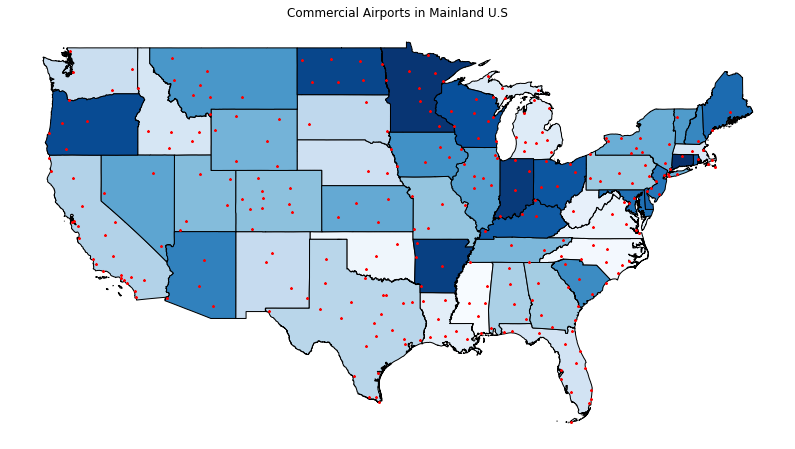

In [12]:
fig, ax1 = plt.subplots(1,1, figsize=(14, 10))
state_gdf.plot(ax = ax1, linewidth = 1, edgecolor = 'black',cmap="Blues")
airports_gdf.plot(ax=ax1, marker='*', color='red', markersize=5)
ax1.set_title("Commercial Airports in Mainland U.S")
ax1.set_axis_off()

We can see there are concentrations around big cities, and some even follow in interestingly shaped lines, possibly highways. 

Next I will prepare for some looks at delays, subsetting our data by delays using boolean masking.

In [13]:
mask = flights_df['ARRIVAL_DELAY'] >= 15
delay_df = flights_df[mask]
delay_df.head()

#amount in subset
len(delay_df)

1003360

In [14]:
delay_mean = delay_df['ARRIVAL_DELAY'].mean()
delay_median = delay_df['ARRIVAL_DELAY'].median()

print("National Delay Mean:", round(delay_mean,2), "Minutes")
print("National Delay Median:", round(delay_median,2), "Minutes")

National Delay Mean: 59.14 Minutes
National Delay Median: 37.0 Minutes


Lastly in the overview I will make a simple pie chart, (much improved from the old one) so we can see the breakdown of delay reasons. You will notice that a bulk of delays are from our own system and bureaucracy at this first glance.

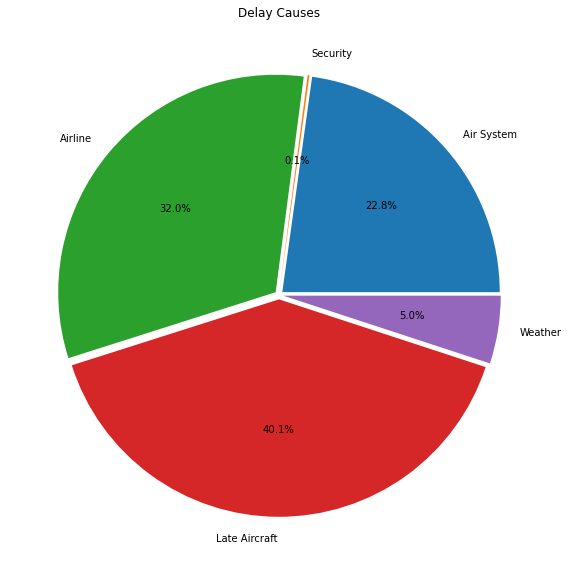

In [15]:
pie_list = [delay_df['AIR_SYSTEM_DELAY'].sum(), delay_df['SECURITY_DELAY'].sum(), delay_df['AIRLINE_DELAY'].sum(),
           delay_df['LATE_AIRCRAFT_DELAY'].sum(), delay_df['WEATHER_DELAY'].sum()]

labels = 'Air System', 'Security', 'Airline', 'Late Aircraft', 'Weather'
fig, ax1 = plt.subplots(1,1, figsize=(14, 10))
ax1.pie(pie_list, labels=labels, autopct='%1.1f%%', explode=(.02,.02,.02,.02,.02));
ax1.set_title("Delay Causes");

Now that we have looked into some of the basic overview, and have a feel for the data let's break it down a bit further.

## Airline Delays
Next, let's take a small look at what airlines have the most delays and see if thereis any relation with the following airport investigation.

Text(0.5, 1.0, 'Delays by Airline')

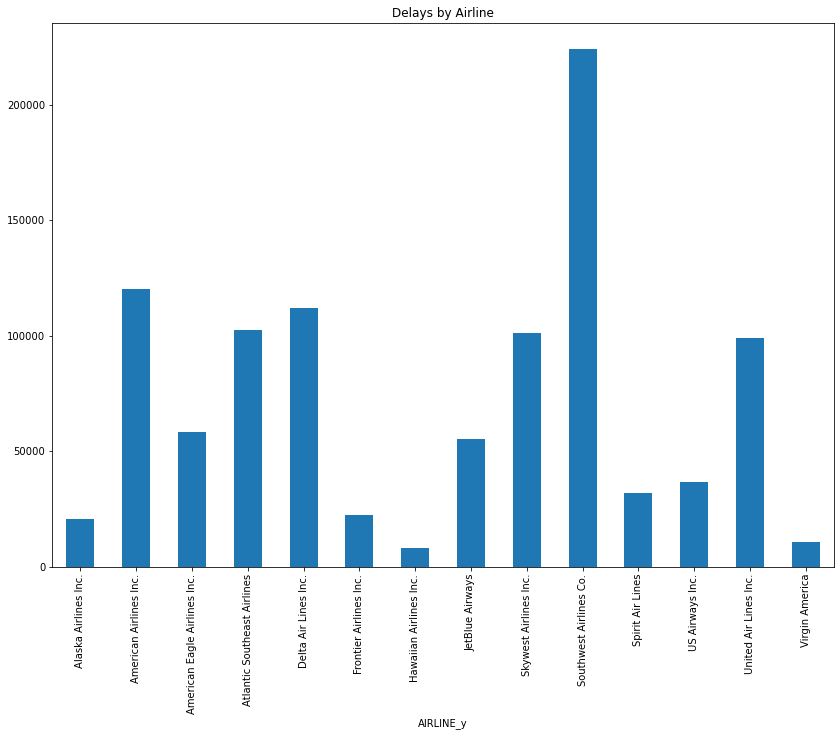

In [16]:
airline_delays = delay_df.groupby('AIRLINE_y').count()
#airline_delays.head()
airline_delays = airline_delays[['AIRLINE_x']]

fig, ax1 = plt.subplots(1,1, figsize=(14, 10))
airline_delays.plot.bar(ax=ax1, legend = False)
ax1.set_title('Delays by Airline')

As you can see in this bar graph, there is one major outlier, Southwest Airlines. Most of the traditional airlines are one the same playing field in delay amounts, such as Delta, American, and United. Southwest is more budget driven, also with no assigned seating, which could be a cause to look deeper into on a micro level. On a larger scale Southwest uses the point to point model of flying more, meaning less reliance on hubs. they still have hubs, but also many more direct flights than like American. Another topic I explore, and would like to contiue looking into as I progress through this interest. 

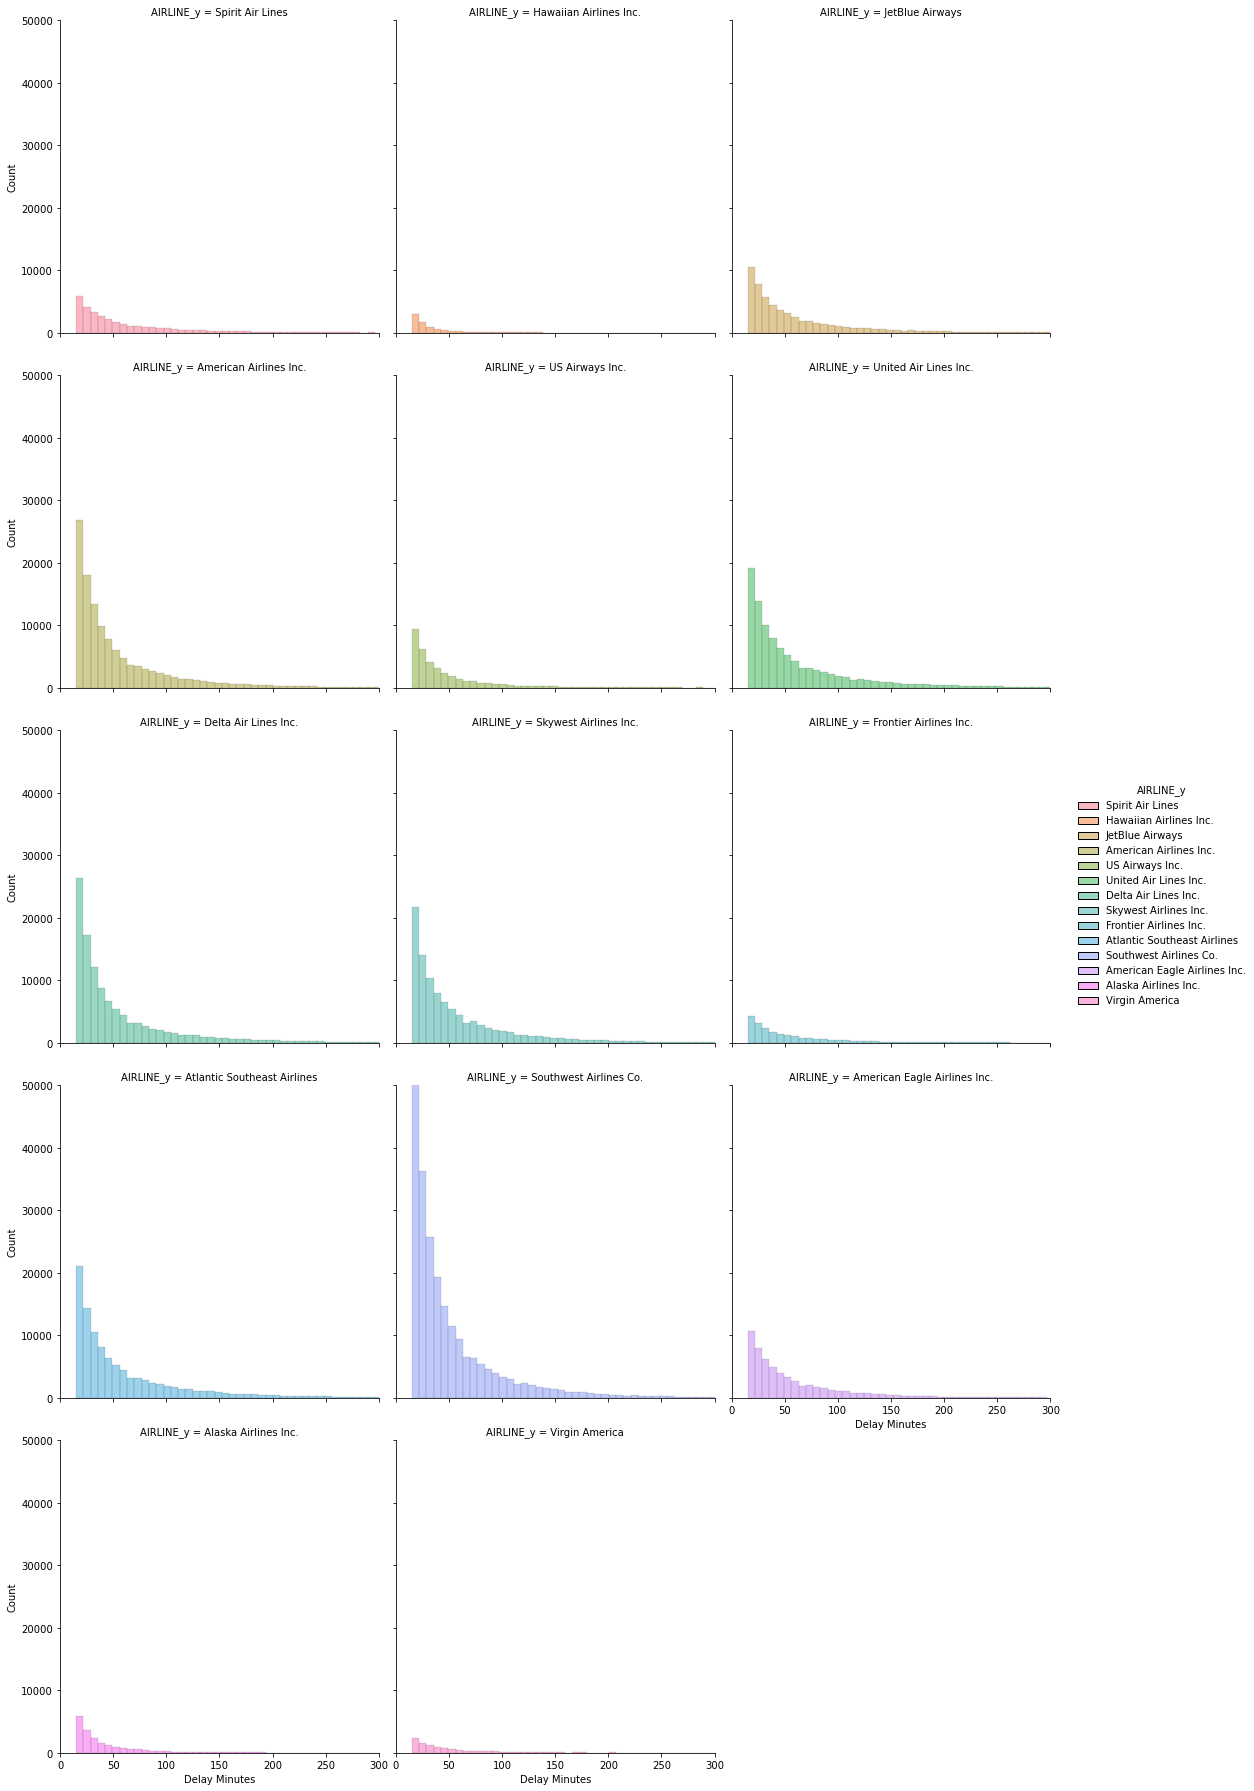

In [17]:
airline_hists = sns.displot(data=delay_df, x='ARRIVAL_DELAY', col='AIRLINE_y', col_wrap=3, bins = 285, hue = 'AIRLINE_y')
airline_hists.set(ylim=(0,50000), xlim=(0,300), xlabel='Delay Minutes')

Lastly on our glance into airlines, there you can see on all the airlines they have large amounts of small delays that snowball. This time I am only looking at delays not including the first 15 minutes as per the FAA definition of a delay. Large delays are almost nonexistent, but there are cancellations in most cases.

Now let's look at airports as a whole, our busiest, and how airline travel models (hub and spoke / point to point) could be effected each

## Airport Delays

In [18]:
#prepping counts for airport delays
airport_delays = delay_df.groupby('DESTINATION_AIRPORT').count()

/tmp/ipykernel_50118/1141489215.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  airports_gdf['centroid_column'] = airports_gdf.centroid
/home/atramirez/anaconda3/envs/geoenv2/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/atramirez/anaconda3/envs/geoenv2/lib/python3.9/site-packages/pandas/core/frame.py:9190: FutureWarning: Passing 'suffixes' which cause duplicate columns {'IATA_CODE_y'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


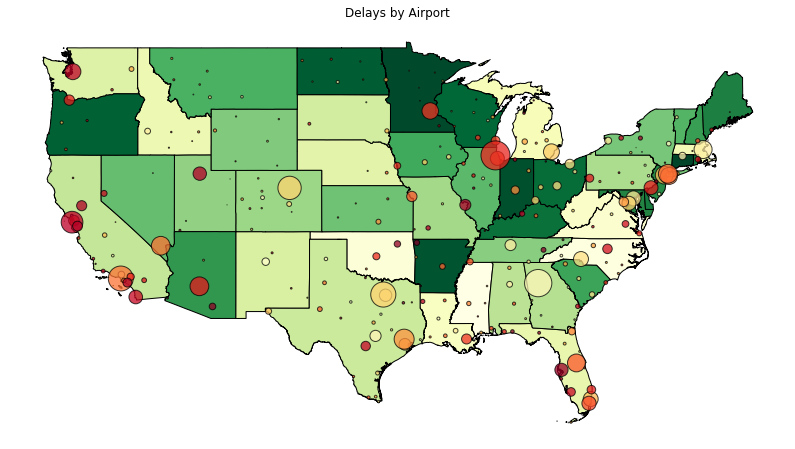

In [19]:
fig, ax1 = plt.subplots(1,1, figsize=(14, 10))
airports_gdf['centroid_column'] = airports_gdf.centroid
airports_gdf2 = airports_gdf.set_geometry('centroid_column')

#merge airport delays with the new centroid data
airports_gdf2 = airports_gdf2.merge(airport_delays, left_on = 'IATA_CODE', right_on = 'DESTINATION_AIRPORT', how = 'left')

state_gdf.plot(ax = ax1,  edgecolor='black', cmap='YlGn', facecolor=(.95, .95, .95))
airports_gdf2.plot(ax=ax1, markersize = airports_gdf2.ARRIVAL_DELAY/70 ,alpha = .75, cmap = 'YlOrRd', edgecolor= 'black', legend=True)
ax1.set_title("Delays by Airport")
ax1.set_axis_off()

You may notice that many of the busier airports around large cities have more delays as expected, but the big thing that jumps out at me are how high hub airports are, yes they have more traffic, but I want to explore if there is more to it than that. In here we will just look at some distribution and flight shares by airlines, but I plan to continue to analyize flight routing and other variables for specific airports. Let's look at the busiest airports to scratch the surface.

Text(0.5, 1.0, '10 Busiest Airports by Flights')

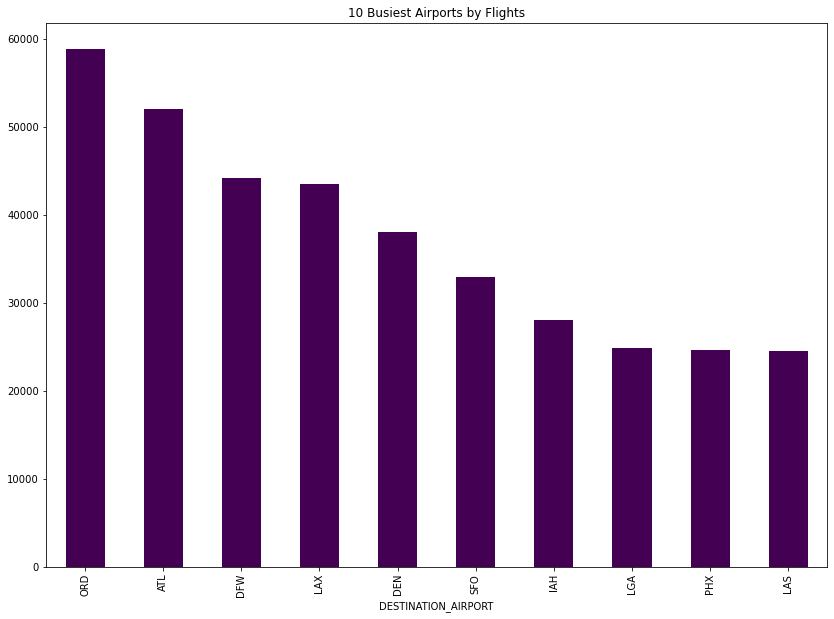

In [20]:
#groups by airport, sorts by highest value, and will then only take the first 10
top10_airports = delay_df.groupby('DESTINATION_AIRPORT').count()
top10_airports = top10_airports.sort_values(by = 'ORIGIN_AIRPORT',ascending=False)
top10_airports = top10_airports[['ORIGIN_AIRPORT']]
top10_airports = top10_airports[:10]

fig, ax1 = plt.subplots(1,1, figsize=(14, 10))
top10_airports.plot.bar(ax=ax1, legend = False, cmap = 'viridis')
ax1.set_title('10 Busiest Airports by Flights')


In [21]:
# busy_airports = flights_df['DESTINATION_AIRPORT'] == 'ORD', 'DFW'
options = ['ORD','DFW','DEN','IAH','ATL','LAX','LAS','MSP','PHX','SFO']
mask = flights_df['ARRIVAL_DELAY'] >= 0
flights_df_nn = flights_df[mask]
busy_airports = flights_df_nn[flights_df['DESTINATION_AIRPORT'].isin(options)]
#len(busy_airports)

/tmp/ipykernel_50118/4021562730.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  busy_airports = flights_df_nn[flights_df['DESTINATION_AIRPORT'].isin(options)]


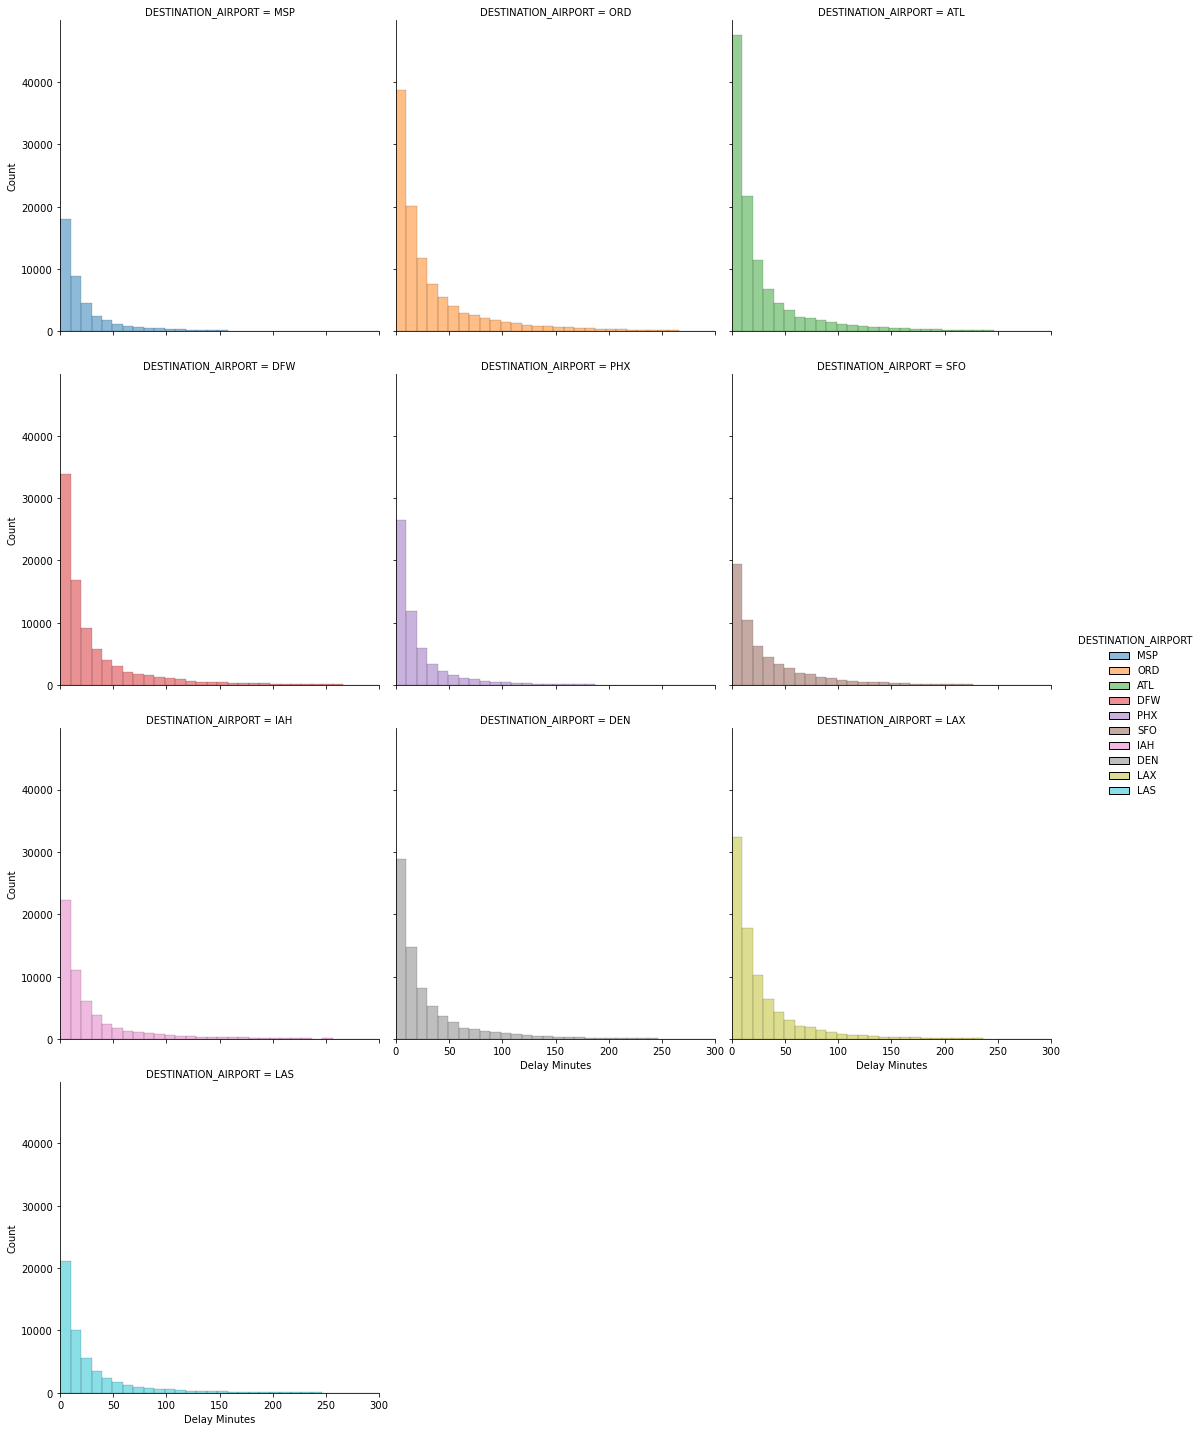

In [22]:
sns.color_palette('mako', as_cmap=True)
airport_hists = sns.displot(data=busy_airports, x='ARRIVAL_DELAY', col='DESTINATION_AIRPORT', col_wrap = 3, bins=200, hue='DESTINATION_AIRPORT')
airport_hists.set(xlim=(0,300), xlabel='Delay Minutes')

This shows the delay distribution of each airport, which increases with the traffic. In general that is all we can get out of this, breaking it down further by airline share at each hub, seeing if our larger traditional airlines hold up to the more point to point models, or regional airlines. Each of the hub airports such as ATL, ORD, and DFW will have high share with Delta, United, and American respectively. We can see if the delays for each are higher in proportion with traffic numbers.

## Observations and Conclusions

- This was definitly cut down a bit from the previous R version

In this exploration I looked at the surface at some different areas, and made further questions to explore deeper. To recap the main points:
- Large data set of 5.8 million entries
- NAs for delay reasons needed to be set to 0
- Drop NAs from sets before joining (latitiude, longitude for airports)
- Join our tables to one big dataset containing everything that can be used

Overview:
- Out of the five delays reasons about 2/3s from 3 of the reasons
- Security delays are negligible
- Weather is much less of a problem than you would expect, but can show on some airports like O'Hare, or Atlanta
- ~80% of flights are on time, ~20% delayed

Airlines: 
- Airlines control alot of aspects of delays
- Airlines often bank flights at hub airports
- Distributions show that all have a large collection of small delays
- Soutwest a non-Traditional airline has higher delays

Airports:
- Hub airports are some of the busiest airports and follow delay numbers
- Focus on big cities
- More delays at busy airports, hinting at congestion, or banking problems

10 Busiest Airports:
- Almost every one is a hub airport for a major airline
- 40% of all flights are from these 10 airports
- 36% of all delays are from these 10 airports
- Most delays are in our "control", mainly being airline process, or waiting on aircraft

Overall with an overwhelming amount of flights happening at a minority of airports where few airlines have control. One delay can lead to a domino effect, and downtime fom airlines lead to much of the issue. This can be further researched, and airports looked at closer to determine what types of flight have more delays, and way to mitigate our ineffcient processes. It is important for cost, and time to find better solutions to over ever growing airline industry as airports begin to reach capacity.

#### Bonus:
Coming from R to Python this set was handeled much better in Python, with only a crash or two. There is more control in plotting and cleaning it feels like, though it takes much more time. 

